# SHARPy TS without PDEControl

Created folder: output/pazy_M16N1Ms20_alpha0001_skin0_te0/
Unable to find source case .pmor.sharpy at ./output/pazy/output/pazy_M16N1Ms20_alpha0001_skin0_te0/pazy_uinf1240_alpha0001
Loaded 104 cases
Saved velocity/eigs array to ./output/pazy/output/fluttersharpy_skin_off_te0//velocity_eigenvalues_alpha0001.txt
[62.83836522597769]
Flutter speeds [62.83836522597769]
RUNNING SHARPY 0.010000 62.838365

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
-------------------------------------------------

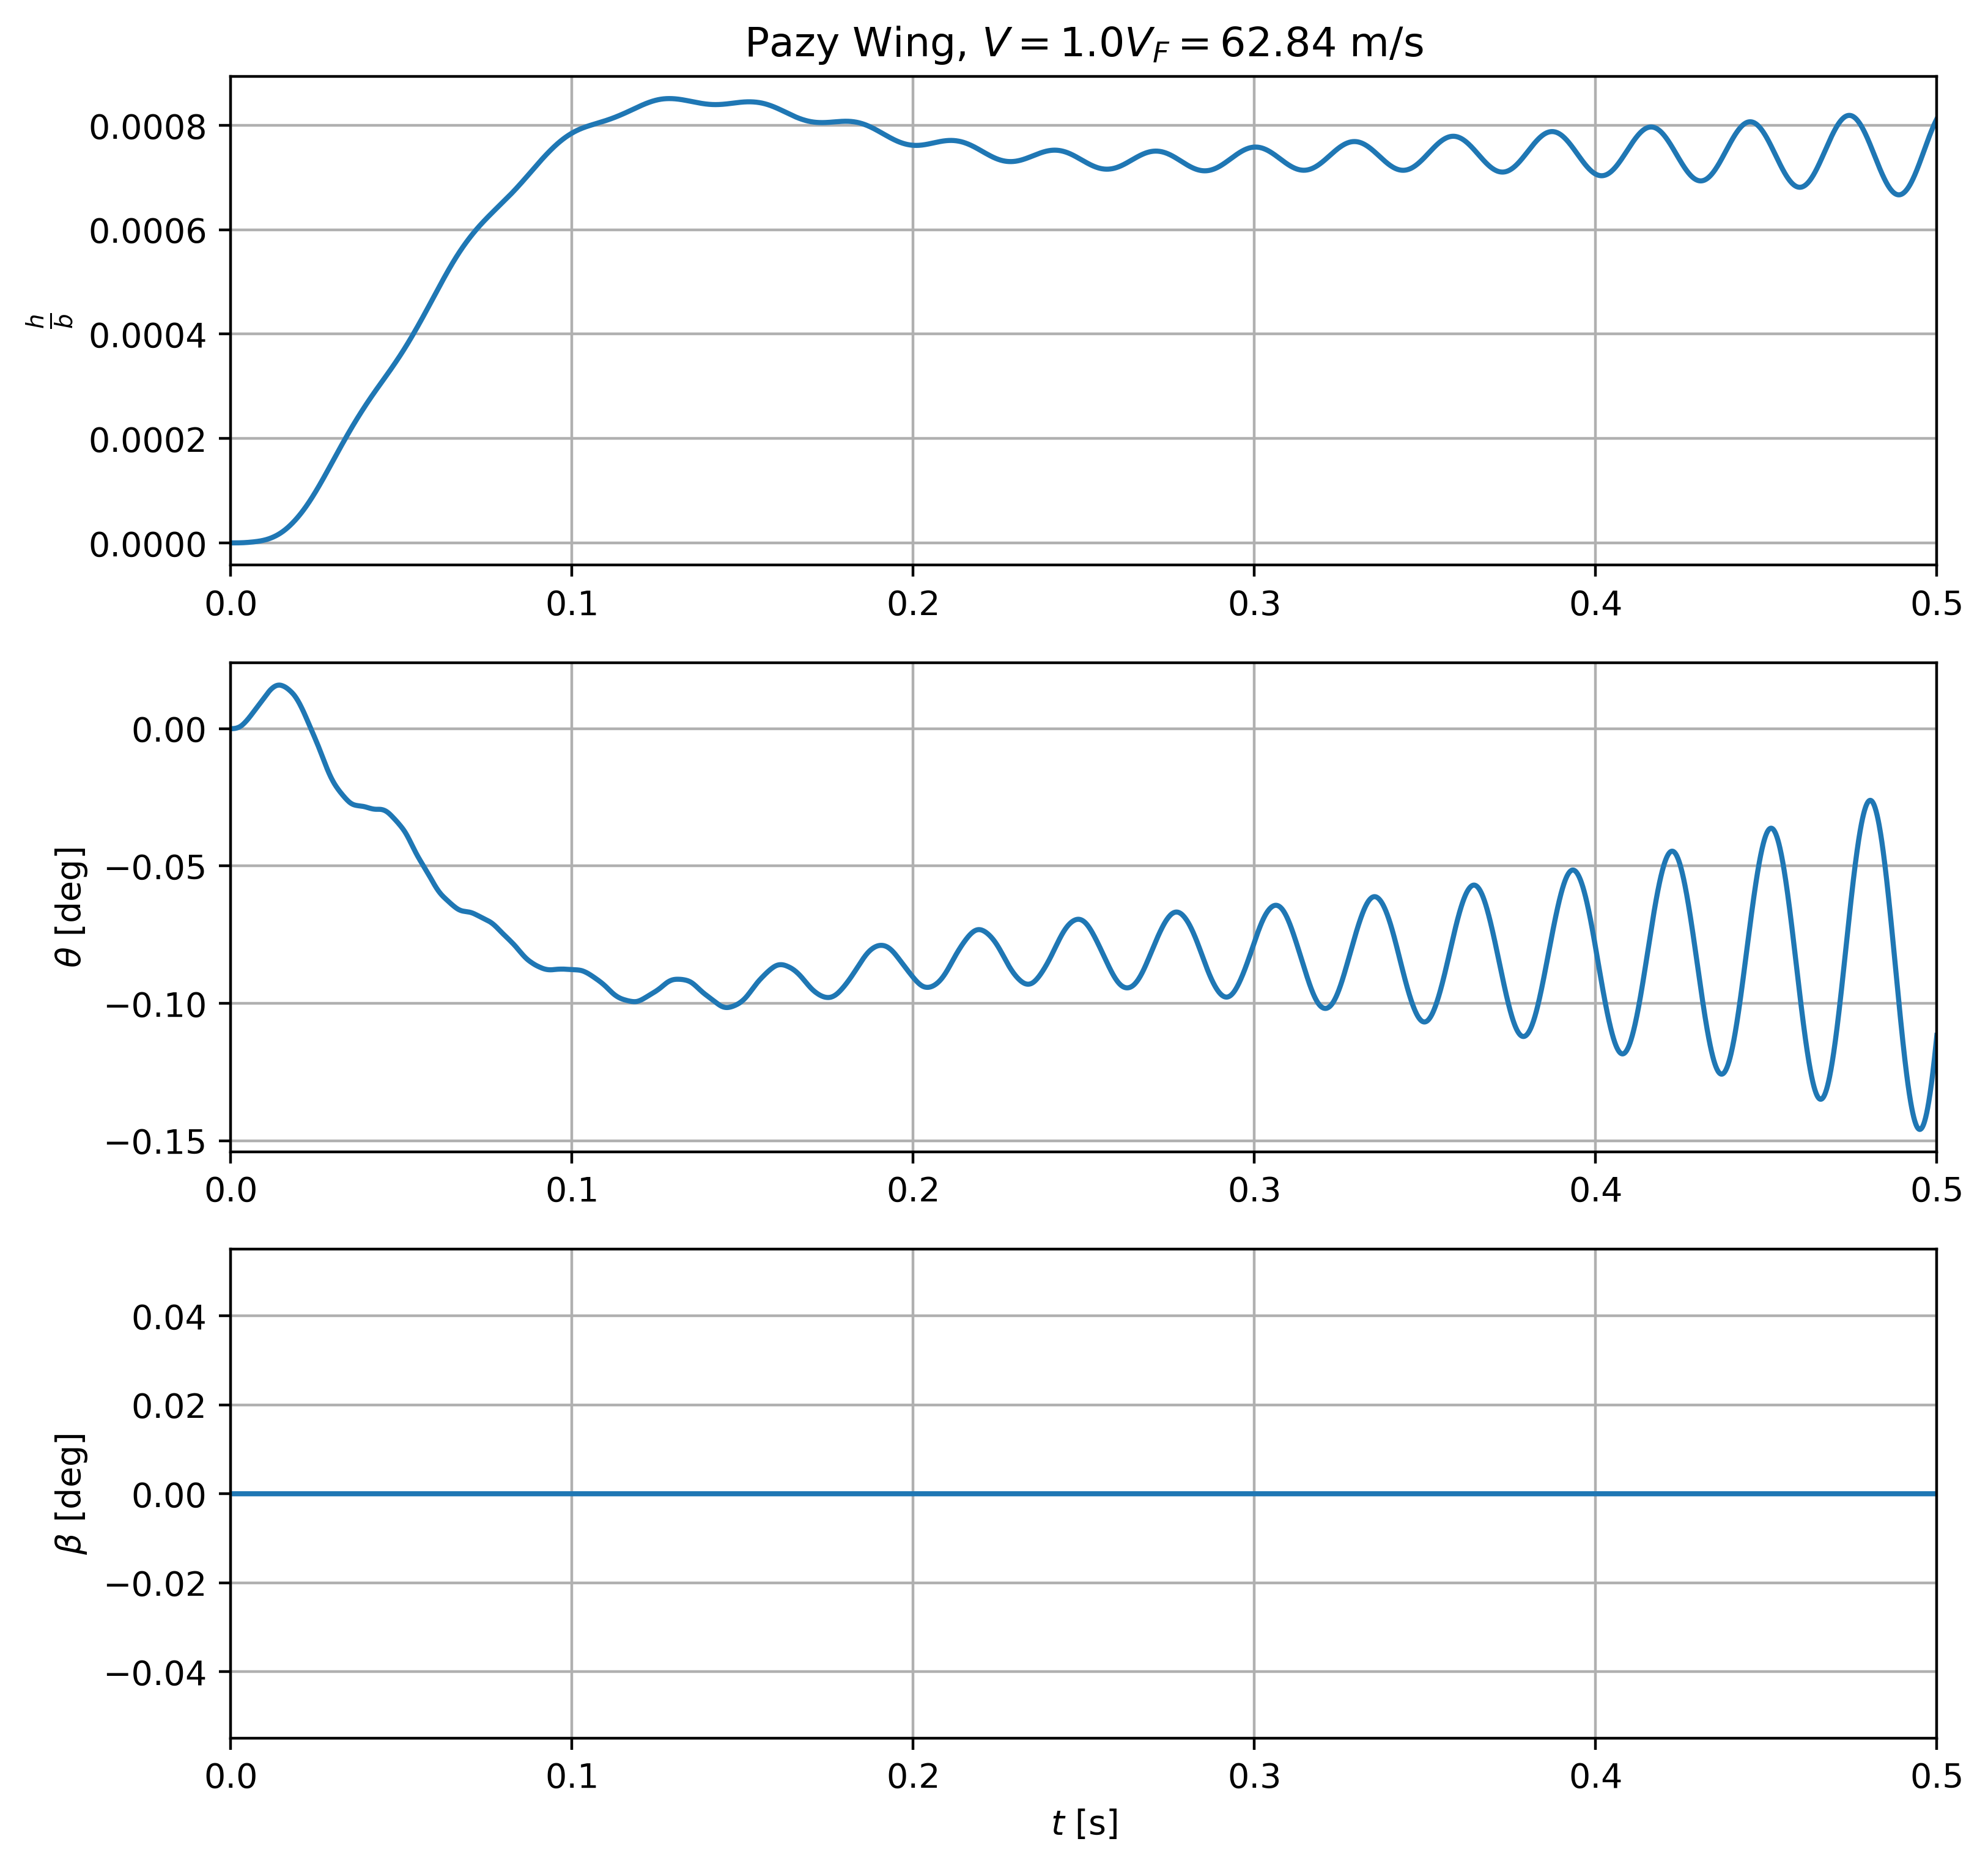

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import re
import scipy.interpolate
from matplotlib.lines import Line2D
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams['figure.figsize'] = (8, 6)
# plt.style.use('dark_background')
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('pazy/sharpy-analysis-tools/')
sys.path.append('pazy/pazy_model/')
import linear.stability as stability
from generate_deformed_tseries import generate_pazy_tseries
import postprocess_deformed_flutter
controlled = False
flap_frac = 0.25
chord_frac = 0.25

# M = 16  # default 16
# N = 1  # default 1
# Ms = 20  # default 20
skin_on = False  # default False
trailing_edge_weight = False  # default False
alpha = 0.01
gravity_on = False
end_time = 0.5

M = 16
N = 1
Ms = 20

pazy_settings = {'num_elem': N,
                 'surface_m': M,
                'controlled': controlled,
                'cs_deflection': [0, 0],
                'cs_span_frac': flap_frac,
                'cs_chord_frac': chord_frac,
                'skin_on': 'off',
                'discretisation_method': 'michigan',
                }


from datetime import datetime
# u_inf_vec = np.linspace(10, 90, 81)
# u_inf_vec = [83]

output_folder_nocontrol = 'output/pazy_M{:g}N{:g}Ms{:g}_alpha{:04g}_skin{:g}_te{:g}/'.format(M, N, Ms, alpha*100, skin_on, trailing_edge_weight)
cases_subfolder_nocontrol = '/M{:g}N{:g}Ms{:g}_skin{:g}_te{:g}/'.format(M, N, Ms, skin_on, trailing_edge_weight)
batch_log = output_folder_nocontrol + 'batch_log_alpha{:04g}'.format(alpha*100)

try:
    os.mkdir(output_folder_nocontrol)
    print(f'Created folder: {output_folder_nocontrol}')
except FileExistsError:
    print(f'Folder exists: {output_folder_nocontrol}')
    pass

vf = postprocess_deformed_flutter.main(M=M, N=N, Ms=Ms, alpha=[alpha], skin=skin_on, te=trailing_edge_weight)
print('Flutter speeds', vf)


with open('{:s}.txt'.format(batch_log), 'w') as f:
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    f.write('SHARPy launch - START\n')
    f.write("date and time = %s\n\n" % dt_string)

    for i, u_inf in enumerate(vf[:1]):
        multiplier = 1.0  # for plot title
        u_inf *= multiplier
        print('RUNNING SHARPY %f %f\n' % (alpha, u_inf))
        case_name = 'pazy_uinf{:04g}_alpha{:04g}'.format(u_inf*10, alpha*100)
        
        dt = 0.1/M/u_inf
        n_tsteps = int(end_time / dt)
        if alpha == 0: alpha += 1e-2
        # n_tsteps = 10
        # end_time = dt * n_tsteps
        
        try:
            sharpy_output_nocontrol = generate_pazy_tseries(u_inf,
                                                            case_name,
                                                            output_folder=output_folder_nocontrol,
                                                            cases_subfolder=cases_subfolder_nocontrol,
                                                            M=M,
                                                            N=N,
                                                            Ms=Ms,
                                                            alpha=alpha,
                                                            gravity_on=gravity_on,
                                                            skin_on=skin_on,
                                                            trailing_edge_weight=trailing_edge_weight,
                                                            model_settings=pazy_settings,
                                                            num_cores=32,
                                                            end_time=end_time,
                                                            )
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            with open('{:s}.txt'.format(batch_log), 'a') as f:
                f.write('%s Ran case %i :::: u_inf = %f\n\n' % (dt_string, i, u_inf))
            
            # print(sharpy_output_nocontrol.structure.timestep_info[0].in_global_AFoR)
            # print(np.degrees(sharpy_output_nocontrol.structure.timestep_info[0].psi))
            # print(np.degrees(sharpy_output_nocontrol.structure.timestep_info[0].quat))
        
            time = np.linspace(0, dt*n_tsteps, n_tsteps)
            tstep_info = sharpy_output_nocontrol.structure.timestep_info
            tip_pos_nocontrol = np.zeros((n_tsteps))
            tip_rot_nocontrol = np.zeros((n_tsteps))
            tip_pos_nocontrol[tip_pos_nocontrol==0] = None
            tip_rot_nocontrol[tip_rot_nocontrol==0] = None
            for it in range(n_tsteps):
                try:
                    tip_pos_nocontrol[it] = tstep_info[it].pos[tstep_info[it].num_node//2-1, 2]
                    tip_rot_nocontrol[it] = tstep_info[it].psi[tstep_info[it].num_elem//2-1, -1, 1]
                except IndexError:
                    pass
            tip_rot_nocontrol = np.degrees(tip_rot_nocontrol)
            aileron = np.zeros((n_tsteps))
            aileron = np.degrees(aileron)
            
            # save nocontrol output to save some time
            file_out = np.vstack([time, tip_pos_nocontrol, tip_rot_nocontrol, aileron]).T  # time, h, theta, beta
            ustr = str(round(u_inf, 2)).replace('.', '_')
            filename = f'{output_folder_nocontrol}/tip_output_{ustr}.txt'
            np.savetxt(filename, file_out, delimiter=',')
            print(filename)

            # plotting, optional (plotted in conjunction with controlled output below)
            fig, ax = plt.subplots(3, figsize=(9, 9), dpi=200)

            ax[0].plot(time, tip_pos_nocontrol / (2*0.55), '-')
            ax[1].plot(time, tip_rot_nocontrol, '-')
            ax[2].plot(time, aileron, '-')

            ax[0].set_title(r'Pazy Wing, $V = {}V_F = {}$ m/s'.format(round(multiplier, 2), round(u_inf, 2)))
            ax[0].set_xlim(0, end_time)
            ax[1].set_xlim(0, end_time)
            ax[2].set_xlim(0, end_time)

            ax[0].grid()
            ax[1].grid()
            ax[2].grid()
            ax[2].set_xlabel(r"$t$ [s]")
            ax[0].set_ylabel(r"$\frac{h}{b}$")
            ax[1].set_ylabel(r'$\theta$ [deg]')
            ax[2].set_ylabel(r'$\beta$ [deg]')

            ustr = str(round(u_inf, 3)).replace('.', '_')
            #     plt.savefig('../Desktop/goland_vf_m{}n{}ms{}_nocontrol.png'.format(M, N, M_star_fact))
            plt.show()
        
        except AssertionError:
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            with open('./{:s}.txt'.format(batch_log), 'a') as f:
                f.write('%s ERROR RUNNING case %f\n\n' % (dt_string, u_inf))



# SHARPy TS with PDEControl

In [1]:
import scipy.optimize as opt
import scipy.signal as sig
import os
import sys
import numpy as np
sys.path.append('pazy/pazy_model/')
from generate_deformed_tseries import generate_pazy_tseries
import postprocess_deformed_flutter
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import re
import scipy.interpolate
from matplotlib.lines import Line2D
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams['figure.figsize'] = (8, 6)
# plt.style.use('dark_background')
sys.path.append('pazy/sharpy-analysis-tools/')
import linear.stability as stability
from generate_deformed_tseries import generate_pazy_tseries
import postprocess_deformed_flutter

skin_on = False  # default False
trailing_edge_weight = False  # default False
alpha = 0.01
gravity_on = False
end_time = 0.5

span = 2 * 0.55

M = 16  # default 16
N = 1  # default 1
Ms = 20  # default 20

flap_frac = 0.5
chord_frac = 0.5
pazy_settings = {'num_elem': N,
                 'surface_m': M,
                'controlled': True,
                'controller_type': 'pde',
                'cs_deflection': [0, 0],
                'cs_span_frac': flap_frac,
                'cs_chord_frac': chord_frac,
                'skin_on': skin_on,
                'discretisation_method': 'michigan',
                }

controller_id = {'aileron': 'ControlSurfacePdeController'}
controller_noise = False
controller_noise_settings = {'noise_mode': 'amplitude', 'max_percentage': 10, 'max_amplitude': np.radians(30),}
controller_lag_ms = 0
controller_p = 5.5  # no negative
controller_i = 150
controller_d = 0
controller_d2 = 0

controller_hp = 0.5 # no negative
controller_hi = 20
controller_hd = 0 # set zero for high freq responses
controller_hd2 = 0

p_steps = 50
i_steps = 50
d_steps = 50
d2_steps = d_steps


from datetime import datetime
# u_inf_vec = np.linspace(10, 90, 81)
# u_inf_vec = [83]

output_folder = './output/controlled/pazy_M{:g}N{:g}Ms{:g}_alpha{:04g}_skin{:g}_te{:g}_control/'.format(M, N, Ms, alpha*100, skin_on, trailing_edge_weight)
cases_subfolder = '/M{:g}N{:g}Ms{:g}_skin{:g}_te{:g}_control/'.format(M, N, Ms, skin_on, trailing_edge_weight)
batch_log = output_folder + 'batch_log_alpha{:04g}_control'.format(alpha*100)

try:
    os.makedirs(output_folder)
    print(f'Created folder: {output_folder}')
except FileExistsError:
    print(f'Folder exists: {output_folder}')
    pass


vf = postprocess_deformed_flutter.main(M=M, N=N, Ms=Ms, alpha=[alpha], skin=skin_on, te=trailing_edge_weight)
print('Flutter speeds', vf)


def amp(tseries):  # returns max average amplitude of wave-like time series
    _max = max(tseries)
    _min = min(tseries)
    avgmax = abs(_max - _min) / 2
    offset = np.mean([_max, _min])
    return avgmax, offset


def period(time, tseries):  # returns period of oscillation
    peaks = sig.find_peaks(tseries)[0]  # returns indices of peaks
    tpeak = time[peaks]
    intervals = np.diff(tpeak)
    return np.mean(intervals)


def peakfit(time, tseries):  # fits a decay function to the peaks
    peaks = sig.find_peaks(tseries)[0]  # returns indices of peaks
    tpeak = time[peaks]
    tspeak = tseries[peaks]
    def testfunc(x, a, b):  # test function, exponential decay here, x here corresponds to t
        return a * np.exp(b * x)
    popt, pcov = opt.curve_fit(testfunc, tpeak, tspeak)
    y = testfunc(time, *popt)
    return y, popt


with open('{:s}.txt'.format(batch_log), 'w') as f:
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    f.write('SHARPy launch - START\n')
    f.write("date and time = %s\n\n" % dt_string)

    for i, u_inf in enumerate(vf[:1]):
        multiplier = 1.0
        u_inf *= multiplier
        print('RUNNING SHARPY %f %f\n' % (alpha, u_inf))
        case_name = 'pazy_uinf{:04g}_alpha{:04g}'.format(u_inf*10, alpha*100)
        
        dt = 0.1/M/u_inf
        n_tsteps = int(end_time / dt)
        # n_tsteps = 5
        # end_time = dt * n_tsteps
        
        ustr = str(round(u_inf, 2)).replace('.', '_')
        try:
            os.mkdir(f'{output_folder}controller_{ustr}/')
            print(f'Created folder: {output_folder}controller_{ustr}/')
        except FileExistsError:
            print(f'Folder exists: {output_folder}controller_{ustr}/')
            pass
        
        # cl = ((0.55*span+0.01*trailing_edge_weight)*9.81) / (0.5*1.225*(u_inf**2)*span*0.1)
        # cl = 2 * np.pi * np.radians(alpha) * 0.9
        cl = 0
        # 1) load factor, reference lift from flight computer, 2) linearise ref wing shape
        # target load factor = 1
        # matlab 0.1 ref val is placeholder
        np.savetxt(f'{output_folder}controller_{ustr}/input.txt', np.full([n_tsteps, 1], cl), delimiter=',')
        
        controller_settings = {'aileron': {'LP': controller_p,
                                    'LI': controller_i,
                                    'LD': controller_d,
                                    'LD2': controller_d2,
                                    'HP': controller_hp,
                                    'HI': controller_hi,
                                    'HD': controller_hd,
                                    'HD2': controller_hd2,
                                    'P_rampup_steps': p_steps,
                                    'I_rampup_steps': i_steps,
                                    'D_rampup_steps': d_steps,
                                    'D2_rampup_steps': d2_steps,
                                    'order': 1,
                                    'dt': dt,
                                    'controlled_surfaces': [0, 1],
                                    'write_controller_log': True,
                                    # 'input_type': 'lift',
                                    'time_history_input_file': f'{output_folder}controller_{ustr}/input.txt',
                                    'controller_log_route': f'{output_folder}controller_{ustr}/',
                                    'controller_noise': controller_noise,
                                    'controller_noise_settings': controller_noise_settings,
                                    'controller_lag': int(controller_lag_ms/1000/dt),
                                    'output_limit': np.radians(30),  # IN RADIANS, -1 if no limit
                                    'error_pow': 1,
                                    'rho': 1.225,
                                    }
                                }
        alpha1 = alpha + (alpha == 0) * 1e-2
        # alpha1 = alpha
        
        try:
            sharpy_output_control = generate_pazy_tseries(u_inf,
                                                            case_name,
                                                            output_folder=output_folder,
                                                            cases_subfolder=cases_subfolder,
                                                            M=M,
                                                            N=N,
                                                            Ms=Ms,
                                                            alpha=alpha1,
                                                            gravity_on=gravity_on,
                                                            skin_on=skin_on,
                                                            trailing_edge_weight=trailing_edge_weight,
                                                            model_settings=pazy_settings,
                                                            num_cores=32,
                                                            end_time=end_time,
                                                            controller_id=controller_id,
                                                            controller_settings=controller_settings,
                                                            )
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            with open('{:s}.txt'.format(batch_log), 'a') as f:
                f.write('%s Ran case %i :::: u_inf = %f\n\n' % (dt_string, i, u_inf))
            
            data_lp = np.genfromtxt(f'{output_folder}controller_{ustr}/aileron_lp_log.csv', delimiter=',')
            tstep_lp = data_lp[:, 0]
            tctrl_lp = data_lp[:, 1]
            desired_lp = data_lp[:, 2]
            current_lp = data_lp[:, 3]
            error_lp = desired_lp - current_lp
            pctrl_lp = np.degrees(data_lp[:, 4])
            ictrl_lp = np.degrees(data_lp[:, 5])
            dctrl_lp = np.degrees(data_lp[:, 6])
            d2ctrl_lp = np.degrees(data_lp[:, 7])
            nctrl_lp = np.degrees(data_lp[:, -4])
            cap_ctrl_lp = data_lp[:, -3]
            rctrl_lp = np.degrees(data_lp[:, -2])
            ctrl_lp = np.degrees(data_lp[:, -1])
            
            data_hp = np.genfromtxt(f'{output_folder}controller_{ustr}/aileron_hp_log.csv', delimiter=',')
            tstep_hp = data_hp[:, 0]
            tctrl_hp = data_hp[:, 1]
            desired_hp = data_hp[:, 2]
            current_hp = data_hp[:, 3]
            error_hp = desired_hp - current_hp
            pctrl_hp = np.degrees(data_hp[:, 4])
            ictrl_hp = np.degrees(data_hp[:, 5])
            dctrl_hp = np.degrees(data_hp[:, 6])
            d2ctrl_hp = np.degrees(data_hp[:, 7])
            nctrl_hp = np.degrees(data_hp[:, -4])
            cap_ctrl_hp = data_hp[:, -3]
            rctrl_hp = np.degrees(data_hp[:, -2])
            ctrl_hp = np.degrees(data_hp[:, -1])
            
            output_folder_nocontrol = 'output/pazy_M{:g}N{:g}Ms{:g}_alpha{:04g}_skin{:g}_te{:g}/'.format(M, N, Ms, alpha*100, skin_on, trailing_edge_weight)
            filename = output_folder_nocontrol + f'tip_output_{ustr}.txt'
            a = np.loadtxt(filename, delimiter=',')
            t_nocontrol = a[:, 0]
            tip_pos_nocontrol = a[:, 1]
            tip_rot_nocontrol = a[:, 2]

            time = np.linspace(0, dt*n_tsteps, n_tsteps)
            tstep_info_s = sharpy_output_control.structure.timestep_info
            tstep_info_a = sharpy_output_control.aero.timestep_info
            tip_pos = np.zeros((n_tsteps))
            tip_rot = np.zeros((n_tsteps))
            aileron = np.zeros((n_tsteps))
            tip_pos[tip_pos==0] = None
            tip_rot[tip_rot==0] = None
            aileron[aileron==0] = None
            for it in range(0, len(time)):  # fill values up to latest timestep, does not necessarily be all timesteps if iteration ended early due to errors
                try:
                    tip_pos[it] = tstep_info_s[it].pos[tstep_info_s[it].num_node//2-1, 2]
                    tip_rot[it] = tstep_info_s[it].psi[tstep_info_s[it].num_elem//2-1, -1, 1]
                except IndexError:
                    pass
                try:
                    aileron[it] = tstep_info_a[it].control_surface_deflection[0]
                except:
                    pass

            tip_rot = np.degrees(tip_rot)
            aileron = np.degrees(aileron)

            '''print(rctrl)
            print(ctrl)
            print(aileron)
            print(ctrl.shape)
            print(aileron.shape)'''

            # amplitude and offset
            amp_nocontrol, off_nocontrol = amp(tip_rot_nocontrol)
            amp_control, off_control = amp(tip_rot)
            amp_aileron, off_aileron = amp(ctrl_lp + ctrl_hp)
            amp_raw, off_raw = amp(rctrl_lp + rctrl_hp)

            # identifying peaks
            tip_rot_peaks = sig.find_peaks(tip_rot)[0]
            # tip_rot_nocontrol_peaks = sig.find_peaks(tip_rot_nocontrol)[0]

            '''tipfit, params = peakfit(time, np.radians(tip_rot))
            tipfit = np.degrees(tipfit)
            osc_period = period(time, tip_rot)
            print(params)
            '''
            # Plotting
            fig, ax = plt.subplots(7, figsize=(9, 21), dpi=256)

            ax[0].plot(t_nocontrol, tip_pos_nocontrol / span, '-', label='No PDE')
            ax[0].plot(time, tip_pos / span, '-', label='With PDE')

            ax[1].plot(t_nocontrol, tip_rot_nocontrol, '-', label=r'No PDE')
            ax[1].plot(time, tip_rot, '-', label=r'With PDE')
            
            ax[2].plot(tctrl_lp, desired_lp+desired_hp, 'C0-', label='Desired')
            ax[2].plot(tctrl_lp, current_lp+current_hp, 'C1-', label='Current')
            ax[2].plot(tctrl_lp, error_lp+error_hp, 'C2-', label='Error')
            
            ax[3].plot(tctrl_lp, desired_lp, 'C0-', label='Desired LP')
            ax[3].plot(tctrl_lp, current_lp, 'C1-', label='Current LP')
            ax[3].plot(tctrl_lp, error_lp, 'C2-', label='Error LP')
            
            ax[3].plot(tctrl_hp, desired_hp, 'C0--', label='Desired HP')
            ax[3].plot(tctrl_hp, current_hp, 'C1--', label='Current HP')
            ax[3].plot(tctrl_hp, error_hp, 'C2--', label='Error HP')
            
            tctrl = tctrl_lp
            rctrl = ctrl_lp + ctrl_hp
            ctrl = ctrl_lp + ctrl_hp
            pctrl = pctrl_lp + pctrl_hp
            ictrl = ictrl_lp + ictrl_hp
            dctrl = dctrl_lp + dctrl_hp
            d2ctrl = d2ctrl_lp + d2ctrl_hp


            if (rctrl == ctrl).all():
                ax[-3].plot(tctrl, ctrl, '-', label='Sum')
            else:
                ax[-3].plot(tctrl, rctrl, '-', label='Sum (raw)')
                ax[-3].plot(tctrl, ctrl, '-', label='Sum (capped)')
            ax[-3].plot(tctrl, pctrl, '--', label=r'$P$', alpha=0.5, linewidth=0.75)
            ax[-3].plot(tctrl, ictrl, '--', label=r'$I$', alpha=0.5, linewidth=0.75)
            ax[-3].plot(tctrl, dctrl, '--', label=r'$D$', alpha=0.5, linewidth=0.75)
            # ax[-3].plot(tctrl, d2ctrl, '--', label=r'$D_2$', alpha=0.5, linewidth=0.75)
            
            ax[-2].plot(tctrl_lp, ctrl_lp, '-', label='Sum LP')
            ax[-2].plot(tctrl_lp, pctrl_lp, '--', label=r'$P_L={}$'.format(controller_p), alpha=0.5, linewidth=0.75)
            ax[-2].plot(tctrl_lp, ictrl_lp, '--', label=r'$I_L={}$'.format(controller_i), alpha=0.5, linewidth=0.75)
            ax[-2].plot(tctrl_lp, dctrl_lp, '--', label=r'$D_L={}$'.format(controller_d), alpha=0.5, linewidth=0.75)
            # ax[-2].plot(tctrl_lp, d2ctrl_lp, '--', label=r'$D_{}={}$'.format(r'{2L}', controller_d2), alpha=0.5, linewidth=0.75)
            
            ax[-1].plot(tctrl_hp, ctrl_hp, '-', label='Sum HP')
            ax[-1].plot(tctrl_hp, pctrl_hp, '--', label=r'$P_H={}$'.format(controller_hp), alpha=0.5, linewidth=0.75)
            ax[-1].plot(tctrl_hp, ictrl_hp, '--', label=r'$I_H={}$'.format(controller_hi), alpha=0.5, linewidth=0.75)
            ax[-1].plot(tctrl_hp, dctrl_hp, '--', label=r'$D_H={}$'.format(controller_hd), alpha=0.5, linewidth=0.75)
            # ax[-1].plot(tctrl_hp, d2ctrl_hp, '--', label=r'$D_{}={}$'.format(r'{2H}', controller_hd2), alpha=0.5, linewidth=0.75)
            

            # prepare noise string
            if controller_noise_settings['noise_mode'] == 'percentage':
                noisestr = '{}'.format(controller_noise_settings['max_percentage']) + r'%'
            elif controller_noise_settings['noise_mode'] == 'amplitude':
                noisestr = '{}'.format(np.degrees(controller_noise_settings['max_amplitude'])) + '$^{\circ}$'

            title = r'Pazy Wing, $V = {:.2f}V_F = {:.2f}$ '.format(multiplier, u_inf) + 'm s$^{-1}$'
            if controller_noise and controller_lag_ms == 0:
                ax[0].set_title(title + ', with max. {} controller noise'.format(noisestr))
            elif controller_noise and controller_lag_ms > 0:
                ax[0].set_title(title + ', with controller noise, controller lag = {} ms'.format(round(controller_lag_ms)))
            elif controller_noise is False and controller_lag_ms > 0:
                ax[0].set_title(title + ', controller lag = {} ms'.format(round(controller_lag_ms)))
            else:
                ax[0].set_title(title)

            
            ax[-1].set_xlabel(r"$t$ [s]")
            
            ax[0].set_ylabel(r"$\frac{h}{b}$")
            ax[1].set_ylabel(r'$\theta$ [deg]')
            ax[2].set_ylabel(r'$C_L$')
            ax[3].set_ylabel(r'$C_{}$'.format('{L_{LP/HP}}'))
            ax[-3].set_ylabel(r'$\beta$ [deg]')
            ax[-2].set_ylabel(r'$\beta_{LP}$ [deg]')
            ax[-1].set_ylabel(r'$\beta_{HP}$ [deg]')
            
            for _ax in ax:
                _ax.set_xlim(0, end_time)
                _ax.grid()
                _ax.legend(loc=3, fontsize=8)

            # prepare strings for saving files
            bstr = str(flap_frac).replace('.', '_')
            cstr = str(chord_frac).replace('.', '_')
            ustr = str(round(u_inf, 2)).replace('.', '_')
            pstr = str(controller_p).replace('.', '_')
            istr = str(controller_i).replace('.', '_')
            dstr = str(controller_d).replace('.', '_')
            d2str = str(controller_d2).replace('.', '_')
            lstr = str(round(controller_lag_ms)).replace('.', '_')
            nstr = 0
            if controller_noise_settings['noise_mode'] == 'percentage' and controller_noise:
                nstr = ('{}pct'.format(controller_noise_settings['max_percentage'])).replace('.', '_')
            elif controller_noise_settings['noise_mode'] == 'amplitude' and controller_noise:
                nstr = ('{}deg'.format(np.degrees(controller_noise_settings['max_amplitude']))).replace('.', '_')

            plt.savefig(f'{output_folder}/v{ustr}_m{M}n{N}ms{Ms}_b{bstr}c{cstr}_p{pstr}i{istr}d{dstr}d2{d2str}_noise{nstr}_lag{controller_lag_ms}ms.png', bbox_inches='tight')
            plt.show()
        
        except AssertionError:
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            with open('./{:s}.txt'.format(batch_log), 'a') as f:
                f.write('%s ERROR RUNNING case %f\n\n' % (dt_string, u_inf))



Folder exists: ./output/controlled/pazy_M16N1Ms20_alpha0001_skin0_te0_control/
Unable to find source case .pmor.sharpy at ./output/pazy/output/pazy_M16N1Ms20_alpha0001_skin0_te0/pazy_uinf1240_alpha0001
Loaded 104 cases
Saved velocity/eigs array to ./output/pazy/output/fluttersharpy_skin_off_te0//velocity_eigenvalues_alpha0001.txt
[62.83836522597769]
Flutter speeds [62.83836522597769]
RUNNING SHARPY 0.010000 62.838365

Folder exists: ./output/controlled/pazy_M16N1Ms20_alpha0001_skin0_te0_control/controller_62_84/
--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##

# Standalone plot function

In [3]:
######## DEFINE YOUR ARGS ########
M = 16
N = 1
Ms = 20
alpha = 0.01
skin_on = False
trailing_edge_weight = False
end_time = 1
u_inf = vf[-1]
dt = 0.1/M/u_inf
n_tsteps = int(end_time / dt)
######## DEFINE YOUR ARGS ########

data = np.genfromtxt(f'{output_folder}controller_{ustr}/aileron_log.csv', delimiter=',')
tstep = data[:, 0]
tctrl = data[:, 1]
desired = data[:, 2]
current = data[:, 3]
error = desired - current
pctrl = np.degrees(data[:, 4])
ictrl = np.degrees(data[:, 5])
dctrl = np.degrees(data[:, 6])
d2ctrl = np.degrees(data[:, 7])
nctrl = np.degrees(data[:, -4])
cap_ctrl = data[:, -3]
rctrl = np.degrees(data[:, -2])
ctrl = np.degrees(data[:, -1])

output_folder_nocontrol = 'output/pazy_M{:g}N{:g}Ms{:g}_alpha{:04g}_skin{:g}_te{:g}/'.format(M, N, Ms, alpha*100, skin_on, trailing_edge_weight)
filename = output_folder_nocontrol + f'tip_output_{ustr}.txt'
a = np.loadtxt(filename, delimiter=',')
t_nocontrol = a[:, 0]
tip_pos_nocontrol = a[:, 1]
tip_rot_nocontrol = a[:, 2]

# time = np.linspace(0, dt*n_tsteps, n_tsteps)
# tstep_info_s = sharpy_output_control.structure.timestep_info
# tstep_info_a = sharpy_output_control.aero.timestep_info
# tip_pos = np.zeros((n_tsteps))
# tip_rot = np.zeros((n_tsteps))
# aileron = np.zeros((n_tsteps))
# tip_pos[tip_pos==0] = None
# tip_rot[tip_rot==0] = None
# aileron[aileron==0] = None
# for it in range(0, len(time)):  # fill values up to latest timestep, does not necessarily be all timesteps if iteration ended early due to errors
#     try:
#         tip_pos[it] = tstep_info_s[it].pos[tstep_info_s[it].num_node//2-1, 2]
#         tip_rot[it] = tstep_info_s[it].psi[tstep_info_s[it].num_elem//2-1, -1, 1]
#     except IndexError:
#         pass
#     try:
#         aileron[it] = tstep_info_a[it].control_surface_deflection[0]
#     except:
#         pass

# tip_rot = np.degrees(tip_rot)
# aileron = np.degrees(aileron)

'''print(rctrl)
print(ctrl)
print(aileron)
print(ctrl.shape)
print(aileron.shape)'''

# amplitude and offset
amp_nocontrol, off_nocontrol = amp(tip_rot_nocontrol)
amp_control, off_control = amp(tip_rot)
amp_aileron, off_aileron = amp(ctrl)
amp_raw, off_raw = amp(rctrl)

# identifying peaks
tip_rot_peaks = sig.find_peaks(tip_rot)[0]
# tip_rot_nocontrol_peaks = sig.find_peaks(tip_rot_nocontrol)[0]

'''tipfit, params = peakfit(time, np.radians(tip_rot))
tipfit = np.degrees(tipfit)
osc_period = period(time, tip_rot)
print(params)
'''
# Plotting
fig, ax = plt.subplots(4, figsize=(9, 12), dpi=200)

ax[0].plot(t_nocontrol, tip_pos_nocontrol / span, '-', label='No PDE')
ax[0].plot(time, tip_pos / span, '-', label='With PDE')

ax[1].plot(t_nocontrol, tip_rot_nocontrol, '-', label=r'No PDE')
ax[1].plot(time, tip_rot, '-', label=r'With PDE')

ax[2].plot(tctrl, desired, label='Desired')
ax[2].plot(tctrl, current, label='Current')
ax[2].plot(tctrl, error, label='Error')
ax[2].set_ylabel(r'$C_L$')

if (rctrl == ctrl).all():
    ax[3].plot(tctrl, ctrl, '-', label='Sum\n'+r'$(A = {:.2f}^{}, D = {:.2f}^{})$'.format(amp_aileron, r'\circ', off_aileron, r'\circ'))
else:
    ax[3].plot(tctrl, rctrl, '-', label='Sum (raw) '+r'$(A = {:.2f}^{}, D = {:.2f}^{})$'.format(amp_raw, r'\circ', off_raw, r'\circ'))
    ax[3].plot(tctrl, ctrl, '-', label='Sum (capped) '+r'$(A = {:.2f}^{}, D = {:.2f}^{})$'.format(amp_aileron, r'\circ', off_aileron, r'\circ'))
ax[3].plot(tctrl, pctrl, '--', label=r'P$={}$'.format(controller_p), alpha=0.5, linewidth=0.75)
ax[3].plot(tctrl, ictrl, '--', label=r'I$={}$'.format(controller_i), alpha=0.5, linewidth=0.75)
ax[3].plot(tctrl, dctrl, '--', label=r'D$={}$'.format(controller_d), alpha=0.5, linewidth=0.75)
ax[3].set_xlim(0, end_time)
#ax[2].set_ylim(-1, 1)
#ax[1].plot(time, np.degrees(current))
#ax[2].plot(time, np.degrees(aileron))

# ax2t = ax[2].twinx()
# ax2t.plot(tctrl, cap_ctrl, 'C4', label='Output capping', alpha=0.5)
# ax2t.set_xlim(0, end_time)
# ax2t.set_ylim(-1.1, 1.1)

# prepare noise string
if controller_noise_settings['noise_mode'] == 'percentage':
    noisestr = '{}'.format(controller_noise_settings['max_percentage']) + r'%'
elif controller_noise_settings['noise_mode'] == 'amplitude':
    noisestr = '{}'.format(np.degrees(controller_noise_settings['max_amplitude'])) + '$^{\circ}$'

if controller_noise and controller_lag_ms == 0:
    ax[0].set_title(r'Pazy Wing, $V = V_F = {:.2f}$ '.format(u_inf) + 'm s$^{-1}$' + ', with max. {} controller noise'.format(noisestr))
elif controller_noise and controller_lag_ms > 0:
    ax[0].set_title(r'Pazy Wing, $V = V_F = {:.2f}$ ' + 'm s$^{-1}$' + ', with controller noise, controller lag = {} ms'.format(round(controller_lag_ms)))
elif controller_noise is False and controller_lag_ms > 0:
    ax[0].set_title(r'Pazy Wing, $V = V_F = {:.2f}$ '.format(u_inf) + 'm s$^{-1}$' + ', controller lag = {} ms'.format(round(controller_lag_ms)))
else:
    ax[0].set_title(r'Pazy Wing, $V = V_F = {:.2f}$'.format(u_inf)+' m s$^{-1}$')
ax[0].set_xlim(0, end_time)
ax[1].set_xlim(0, end_time)
ax[2].set_xlim(0, end_time)

# ax[1].set_ylim(-1, 1)


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
ax[3].set_xlabel(r"$t$ [s]")
ax[0].set_ylabel(r"$\frac{h}{b}$")
ax[1].set_ylabel(r'$\theta$ [deg]')
ax[3].set_ylabel(r'$\beta$ [deg]')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend(loc=0, fontsize=8)

# prepare strings for saving files
bstr = str(flap_frac).replace('.', '_')
cstr = str(chord_frac).replace('.', '_')
ustr = str(round(u_inf, 2)).replace('.', '_')
pstr = str(controller_p).replace('.', '_')
istr = str(controller_i).replace('.', '_')
dstr = str(controller_d).replace('.', '_')
lstr = str(round(controller_lag_ms)).replace('.', '_')
nstr = 0
if controller_noise_settings['noise_mode'] == 'percentage' and controller_noise:
    nstr = ('{}pct'.format(controller_noise_settings['max_percentage'])).replace('.', '_')
elif controller_noise_settings['noise_mode'] == 'amplitude' and controller_noise:
    nstr = ('{}deg'.format(np.degrees(controller_noise_settings['max_amplitude']))).replace('.', '_')

plt.savefig(f'{output_folder}/v{ustr}_m{M}n{N}ms{Ms}_b{bstr}c{cstr}_p{pstr}i{istr}d{dstr}_noise{nstr}_lag{controller_lag_ms}ms.png', bbox_inches='tight')
plt.show()

NameError: name 'tip_rot' is not defined